# Imports

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier

In [86]:
# figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")

# set seed
np.random.seed(42)

# Load Data

In [87]:
X_train = pd.read_csv("../../data/processed/train_data_cleaned.csv")
y_train = pd.read_csv("../../data/processed/train_labels.csv")

In [88]:
X_train = X_train.iloc[:100000] # max 260601
y_train = y_train.iloc[:100000] # max 260601

# Random Forest

In [89]:
# Build random forest classifier
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=20,
                            max_features="sqrt",
                            random_state=42,
                            n_jobs=-1,
                            verbose=1)

In [90]:
# Perform cross validation
cv_results_rf = cross_validate(rf,
                               X_train,
                               y_train["damage_grade"],
                               cv=5,
                               scoring=("accuracy", "matthews_corrcoef"),
                               return_train_score=True,
                               n_jobs=-1,
                               verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished


In [91]:
# Display results
df_cv_results_rf = pd.DataFrame(cv_results_rf).reset_index(names="k-fold")
display(df_cv_results_rf)

# Calculate mean and standard deviation
cv_acc_mean_rf = df_cv_results_rf["test_accuracy"].mean()
cv_acc_std_rf = df_cv_results_rf["test_accuracy"].std()
print(f"Mean Accuracy: {cv_acc_mean_rf:.3f} +/- {cv_acc_std_rf:.3f}")

cv_mcc_mean_rf = df_cv_results_rf["test_matthews_corrcoef"].mean()
cv_mcc_std_rf = df_cv_results_rf["test_matthews_corrcoef"].std()
print(f"Mean MCC: {cv_mcc_mean_rf:.3f} +/- {cv_mcc_std_rf:.3f}")

,k-fold,fit_time,score_time,test_accuracy,train_accuracy,test_matthews_corrcoef,train_matthews_corrcoef
0,0,7.183848,0.210868,0.70305,0.896463,0.438359,0.813120
1,1,7.183848,0.210868,0.69855,0.898988,0.429471,0.817731
2,2,7.121236,0.140759,0.70215,0.894900,0.435110,0.809776
3,3,7.199488,0.340138,0.70195,0.897600,0.435248,0.815072
4,4,7.199488,0.219318,0.69795,0.897388,0.427764,0.814421


Mean Accuracy: 0.701 +/- 0.002
Mean MCC: 0.433 +/- 0.004


# Xgboost

In [92]:
# Build Xgboost classifier
xgb = XGBClassifier(n_estimators=100,
                    max_depth=20,
                    learning_rate=0.1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1,
                    verbosity=1)

In [93]:
# Label encode y_train for Xgboost (expects 0, 1, 2, not 1, 2, 3)
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train["damage_grade"].to_numpy())

In [94]:
# Perform cross validation
cv_results_xgb = cross_validate(xgb,
                                X_train,
                                y_train_encoded,
                                cv=5,
                                scoring=("accuracy", "matthews_corrcoef"),
                                return_train_score=True,
                                n_jobs=-1,
                                verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


In [95]:
# Display results
df_cv_results_xgb = pd.DataFrame(cv_results_xgb).reset_index(names="k-fold")
display(cv_results_xgb)

# Calculate mean and standard deviation
cv_acc_mean_xgb = df_cv_results_xgb["test_accuracy"].mean()
cv_acc_std_xgb = df_cv_results_xgb["test_accuracy"].std()
print(f"Mean Accuracy: {cv_acc_mean_xgb:.3f} +/- {cv_acc_std_xgb:.3f}")

cv_mcc_mean_xgb = df_cv_results_xgb["test_matthews_corrcoef"].mean()
cv_mcc_std_xgb = df_cv_results_xgb["test_matthews_corrcoef"].std()
print(f"Mean MCC: {cv_mcc_mean_xgb:.3f} +/- {cv_mcc_std_xgb:.3f}")

{'fit_time': array([119.92679405, 118.0680697 , 120.47296333, 118.6053021 ,
        118.43257403]),
 'score_time': array([2.05857944, 2.13423038, 2.02124786, 1.98427558, 2.06753111]),
 'test_accuracy': array([0.723  , 0.72515, 0.7226 , 0.71885, 0.72065]),
 'train_accuracy': array([0.9974875, 0.9972   , 0.9971125, 0.99705  , 0.9968625]),
 'test_matthews_corrcoef': array([0.48105723, 0.48529376, 0.47878066, 0.47246447, 0.47644841]),
 'train_matthews_corrcoef': array([0.99547495, 0.99495714, 0.99479924, 0.99468684, 0.99434893])}

Mean Accuracy: 0.722 +/- 0.002
Mean MCC: 0.479 +/- 0.005


# CatBoost

In [96]:
# Create a CatBoost classifier
cb = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function="MultiClass",
    random_seed=42,
    logging_level="Info"
)

In [97]:
# Perform cross validation
cv_results_cb = cross_validate(cb,
                               X_train,
                               y_train["damage_grade"],
                               cv=5,
                               scoring=("accuracy", "matthews_corrcoef"),
                               return_train_score=True,
                               n_jobs=-1,
                               verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.8s finished


In [98]:
# Display results
df_cv_results_cb = pd.DataFrame(cv_results_cb).reset_index(names="k-fold")
display(df_cv_results_cb)

# Calculate mean and standard deviation
cv_acc_mean_cb = df_cv_results_cb["test_accuracy"].mean()
cv_acc_std_cb = df_cv_results_cb["test_accuracy"].std()
print(f"Mean Accuracy: {cv_acc_mean_cb:.3f} +/- {cv_acc_std_cb:.3f}")

cv_mcc_mean_cb = df_cv_results_cb["test_matthews_corrcoef"].mean()
cv_mcc_std_cb = df_cv_results_cb["test_matthews_corrcoef"].std()
print(f"Mean MCC: {cv_mcc_mean_cb:.3f} +/- {cv_mcc_std_cb:.3f}")

,k-fold,fit_time,score_time,test_accuracy,train_accuracy,test_matthews_corrcoef,train_matthews_corrcoef
0,0,42.504350,0.047323,0.7124,0.745563,0.458219,0.523246
1,1,42.930453,0.046871,0.7099,0.743950,0.453449,0.520551
2,2,43.604540,0.031663,0.7111,0.743862,0.454532,0.519789
3,3,43.588942,0.031619,0.7106,0.744850,0.453880,0.521838
4,4,43.150362,0.031244,0.7079,0.745600,0.449472,0.523729


Mean Accuracy: 0.710 +/- 0.002
Mean MCC: 0.454 +/- 0.003


# Comparison Plot

In [99]:
def compare_models_cv_acc_mcc(cv_results_list, model_names, n_samples, ylim, figsize) -> None:
    """
    Plot stacked bar charts to compare cross-validation results of different models. The plot will contain two subplots, one for accuracy and one for MCC. The plot will also contain horizontal guidelines for random guessing and the mean accuracy and MCC.

    :param cv_results_list: A list of dicts of float arrays of shape (n_splits,) that contain the cross-validation results of each model. Follows sklearn.model_selection.cross_validate() output format. See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate for more details. Must contain the following keys: "test_accuracy", "test_matthews_corrcoef" in each dict list element. The length and order of the list must be equal to the length of model_names.
    :type cv_results_list: list
    :param model_names: A list of strings that represent the names of each model. The length and order of the list must be equal to the length of cv_results_list.
    :type model_names: list
    :param n_samples: The number of samples used in the cross-validation.
    :type n_samples: int
    :param ylim: The y-axis limits of the plot. Must be a tuple of two floats. The first float is the lower limit and the second float is the upper limit. The lower limit must be greater than or equal to 0. The upper limit must be less than or equal to 1.
    :type ylim: tuple
    :param figsize: The width and height of the plot in inches. Must be a tuple of two floats. The first float is the width and the second float is the height.
    :type figsize: tuple

    :return: None
    :rtype: None
    """

    # Check
    try:
        assert len(cv_results_list) == len(model_names)
    except AssertionError:
        print("cv_results_list and model_names must have the same length.")
        return

    # Create a figure
    fig, axes = plt.subplots(nrows=1, ncols=len(model_names), figsize=figsize)

    # Set palette
    palette = {
        "test_accuracy": sns.color_palette("Paired")[0],
        "test_matthews_corrcoef": sns.color_palette("Paired")[2]
    }

    # Plot each model
    for i, (cv_results, model_name) in enumerate(zip(cv_results_list, model_names)):
        # Create a dataframe
        df = pd.DataFrame(cv_results).reset_index(names='k-fold')
        df_melt = df[['k-fold', 'test_accuracy', 'test_matthews_corrcoef']].melt(id_vars=['k-fold'], var_name='Metric', value_name='Score')
        # Calculate mean and std
        agg = df_melt.groupby('Metric')['Score'].agg(['mean', 'std'])
        cv_mcc_mean = agg.loc["test_matthews_corrcoef"].at["mean"]
        cv_mcc_std = agg.loc["test_matthews_corrcoef"].at["std"]
        cv_acc_mean = agg.loc["test_accuracy"].at["mean"]
        cv_acc_std = agg.loc["test_accuracy"].at["std"]
        # Plot
        fig_ax = sns.barplot(x='k-fold', y='Score', hue='Metric', data=df_melt, ax=axes[i], dodge=False, errorbar=None, palette=palette)
        axes[i].set_title(f"Test Scoring {model_name}" + "\n" +
                          f"Mean MCC: {cv_mcc_mean:.3f} +/- {cv_mcc_std:.3f}, Mean Accuracy: {cv_acc_mean:.3f} +/- {cv_acc_std:.3f}")
        axes[i].legend().set_visible(False)
        # Add guidelines
        xmin, xmax = axes[i].get_xlim()
        axes[i].hlines(y=0.5, xmin=xmin, xmax=xmax, linestyles="dotted", colors='r', label="0.5")
        axes[i].hlines(y=cv_mcc_mean, xmin=xmin, xmax=xmax, linestyles="dashed", colors=sns.color_palette("Paired")[3], label="Mean MCC")
        axes[i].hlines(y=cv_acc_mean, xmin=xmin, xmax=xmax, linestyles="dashed", colors=sns.color_palette("Paired")[1], label="Mean Accuracy")
        # Set y-axis limits
        plt.setp(axes[i], ylim=ylim)

    # Set legend
    handles, labels = axes[0].get_legend_handles_labels()
    order = [0, 2, 3, 1, 4]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    plt.suptitle(f"Cross Validation Results ({n_samples} samples)", fontweight='bold')

    # Show plot
    plt.tight_layout()
    plt.show()

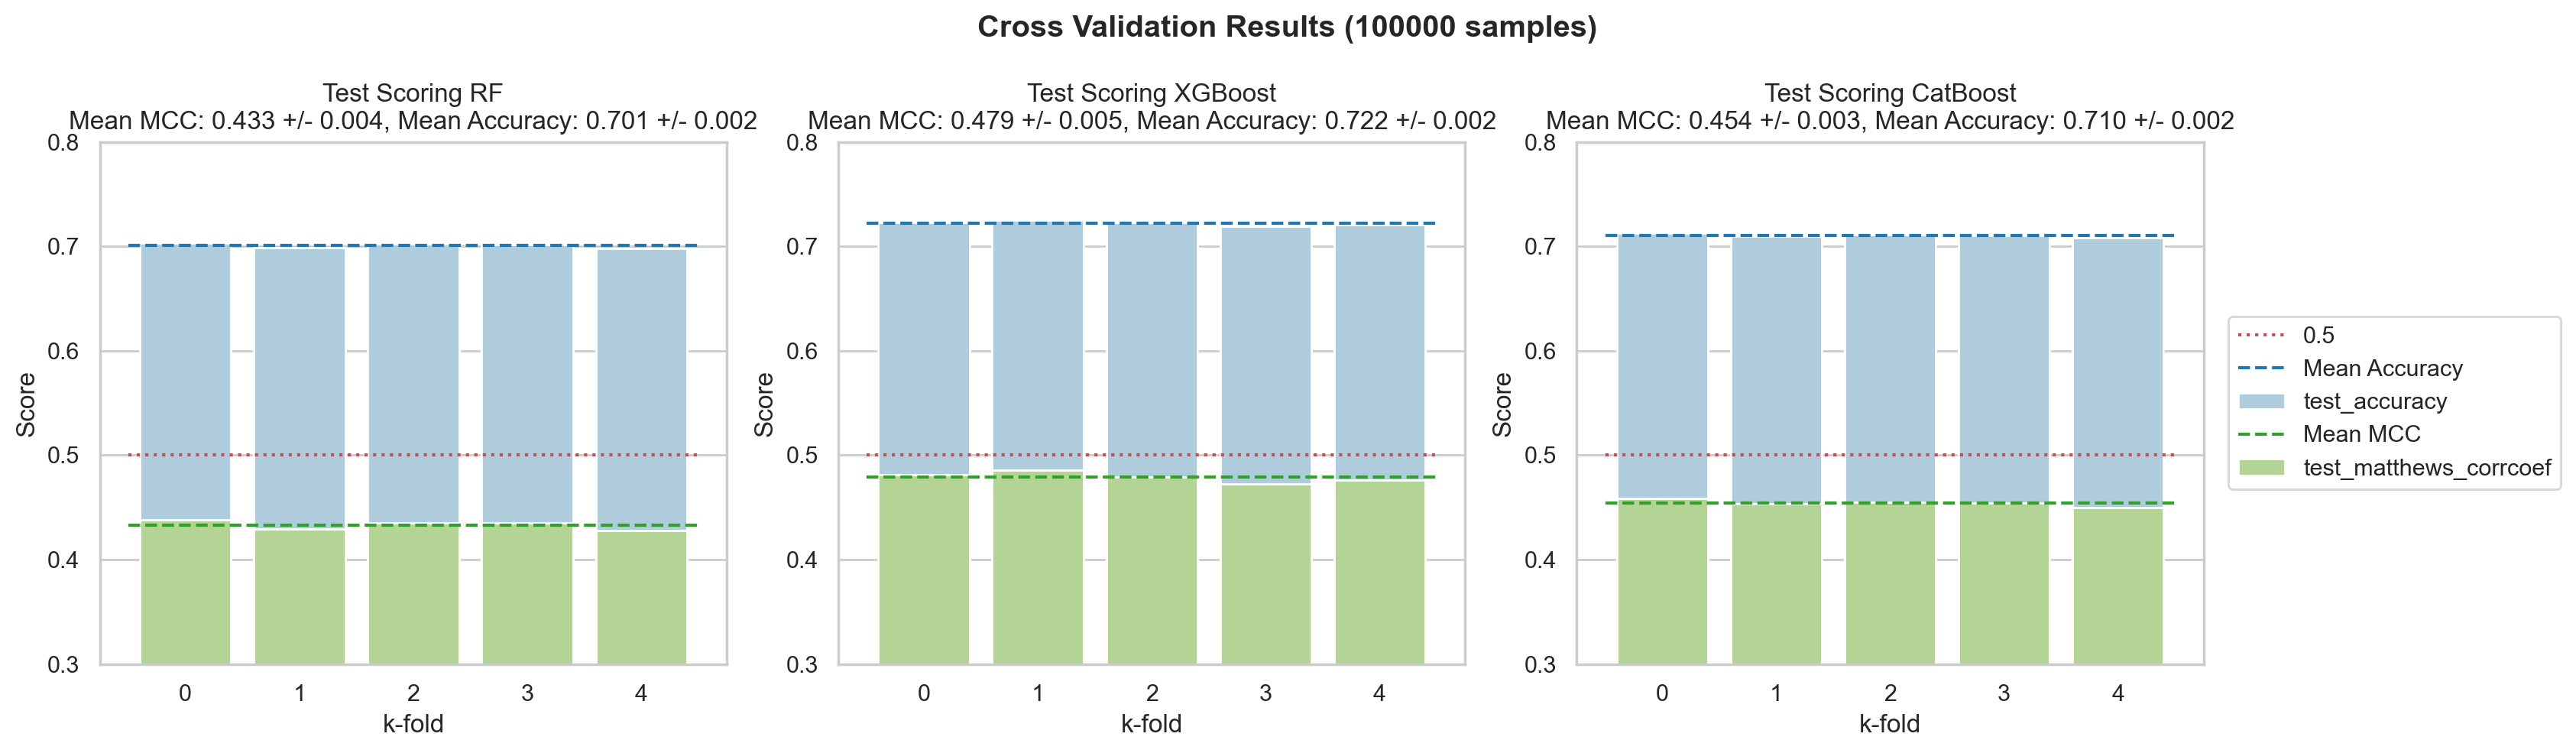

In [100]:
compare_models_cv_acc_mcc([cv_results_rf, cv_results_xgb, cv_results_cb], ["RF", "XGBoost", "CatBoost"], 100000, (0.3, 0.8), (17, 5))